In [21]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import warnings
print("Setup Complete")

Setup Complete


### Read the kaggle datasets as dataframes and find out relevant information for modeling

In [22]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

In [23]:
train_data

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,3658_01,Earth,True,G/593/S,TRAPPIST-1e,4.0,False,0.0,0.0,0.0,0.0,0.0,Kelle Daughttley,True
1,6000_01,Mars,False,NaN,TRAPPIST-1e,19.0,False,781.0,0.0,295.0,613.0,0.0,Forms Bart,False
2,7045_01,Mars,False,D/222/P,55 Cancri e,19.0,False,1043.0,0.0,138.0,0.0,0.0,Range Bara,False
3,6415_01,Mars,True,F/1225/S,TRAPPIST-1e,51.0,False,0.0,0.0,0.0,0.0,0.0,Eang Potie,True
4,1669_01,Mars,False,F/317/S,TRAPPIST-1e,31.0,False,2436.0,0.0,147.0,16.0,0.0,Flams Spane,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4341,2140_01,Earth,False,F/424/P,TRAPPIST-1e,18.0,False,0.0,0.0,698.0,0.0,0.0,Andra Drakeekss,True
4342,3536_01,Europa,True,A/40/S,55 Cancri e,28.0,False,0.0,0.0,0.0,0.0,0.0,Zosmas Ineedeve,True
4343,6020_07,Earth,True,G/974/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,NaN,Tera Hanner,False
4344,3936_01,Earth,False,G/644/S,TRAPPIST-1e,24.0,False,3537.0,0.0,0.0,0.0,0.0,Carley Sancasey,False


In [24]:
# Target column "Transported" is missing in test data set
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4347 entries, 0 to 4346
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4347 non-null   object 
 1   HomePlanet    4234 non-null   object 
 2   CryoSleep     4236 non-null   object 
 3   Cabin         4249 non-null   object 
 4   Destination   4252 non-null   object 
 5   Age           4254 non-null   float64
 6   VIP           4253 non-null   object 
 7   RoomService   4261 non-null   float64
 8   FoodCourt     4268 non-null   float64
 9   ShoppingMall  4250 non-null   float64
 10  Spa           4245 non-null   float64
 11  VRDeck        4255 non-null   float64
 12  Name          4253 non-null   object 
dtypes: float64(6), object(7)
memory usage: 441.6+ KB


In [25]:
# unique id so the column can be dropped before modeling
len(train_data["PassengerId"].unique())

4346

In [26]:
# looks balanced so the column can be dropped before modeling 
len(train_data["Name"].unique())

4236

In [27]:
# looks balanced so the column can be dropped before modeling
len(train_data["Cabin"].unique())

3615

In [28]:
# see https://www.kaggle.com/code/vaasubisht/eda-statisticaltests-gradient-boosting-shap
# most of the columns have missing values but with low percentage compared to the amount of training data
missing_values = train_data.isna().sum().div(train_data.shape[0]).mul(100).to_frame().sort_values(by=0, ascending = False)
missing_values.columns  = ['% missing_values']
missing_values = missing_values[missing_values['% missing_values'] > 0 ]
missing_values

,% missing_values
ShoppingMall,2.554073
VIP,2.508053
CryoSleep,2.439024
Name,2.439024
FoodCourt,2.393005
Cabin,2.323976
VRDeck,2.208928
RoomService,2.185918
HomePlanet,2.024850
Destination,2.001841


### Visualize the unprepared training data

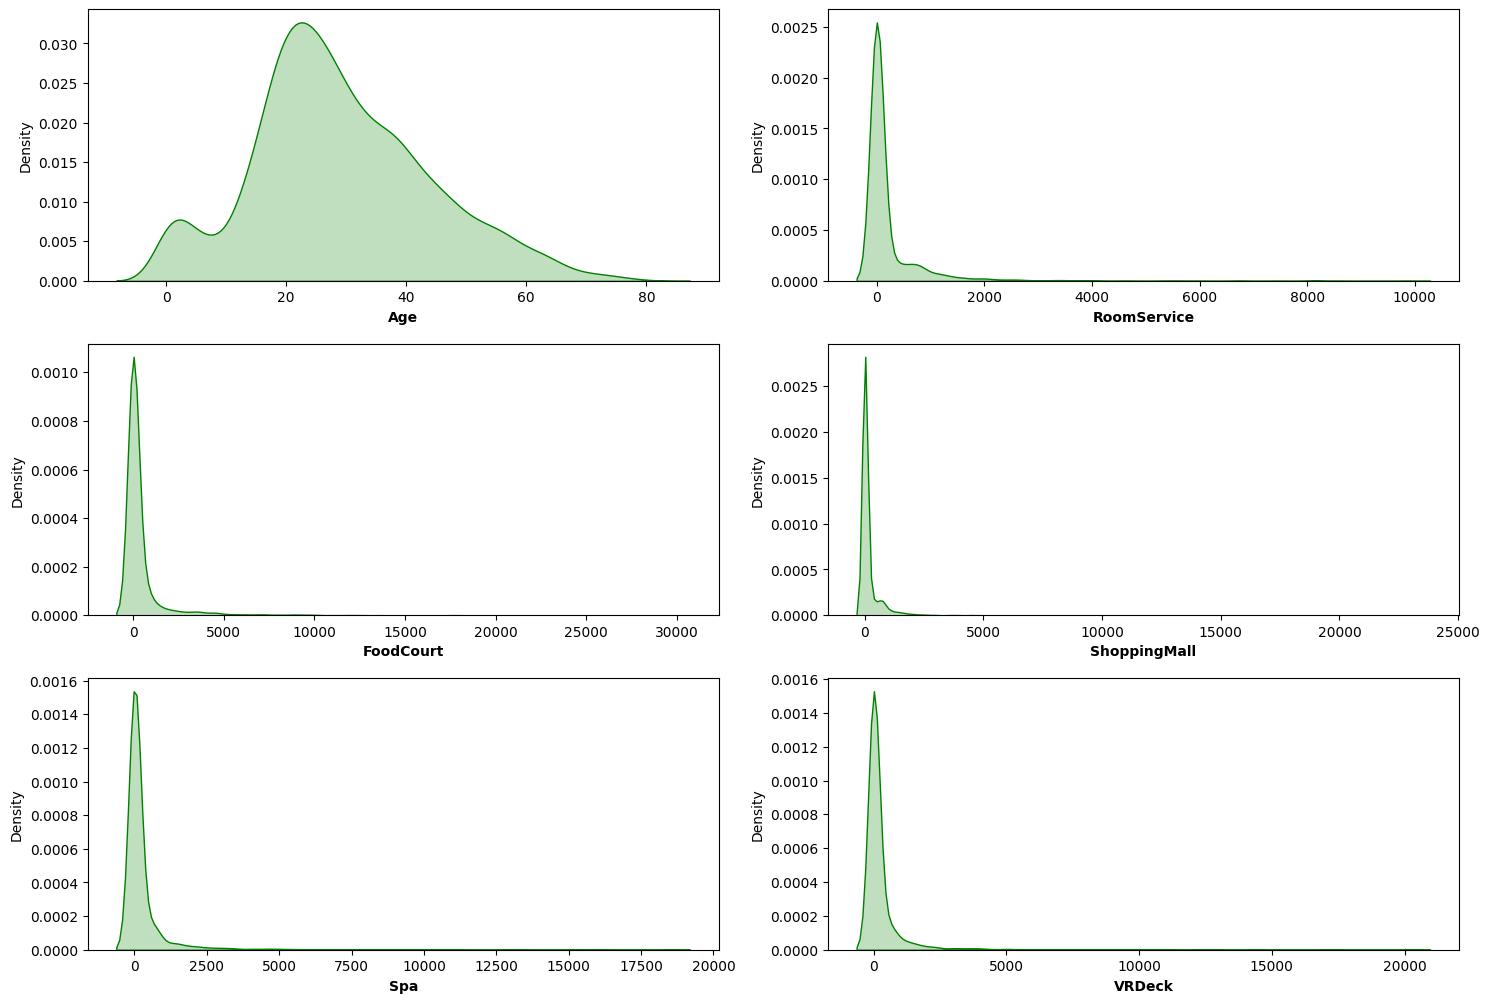

In [30]:
# see https://www.kaggle.com/code/vaasubisht/eda-statisticaltests-gradient-boosting-shap
num_columns = list(train_data[train_data.columns].select_dtypes(include=['float64']).columns)
cat_columns = list(train_data[train_data.columns].select_dtypes(include=['object']).columns)

# kernel density estimate subplots show that most of the numerical columns have inbalanced training data
warnings.filterwarnings("ignore")
plt.figure(figsize=(15, 100))
for i, col in enumerate(num_columns):
    plt.subplot(30, 2, i+1)
    sns.kdeplot(train_data[col], color='green', shade=True)
    plt.xlabel(col, weight='bold')
    plt.tight_layout()

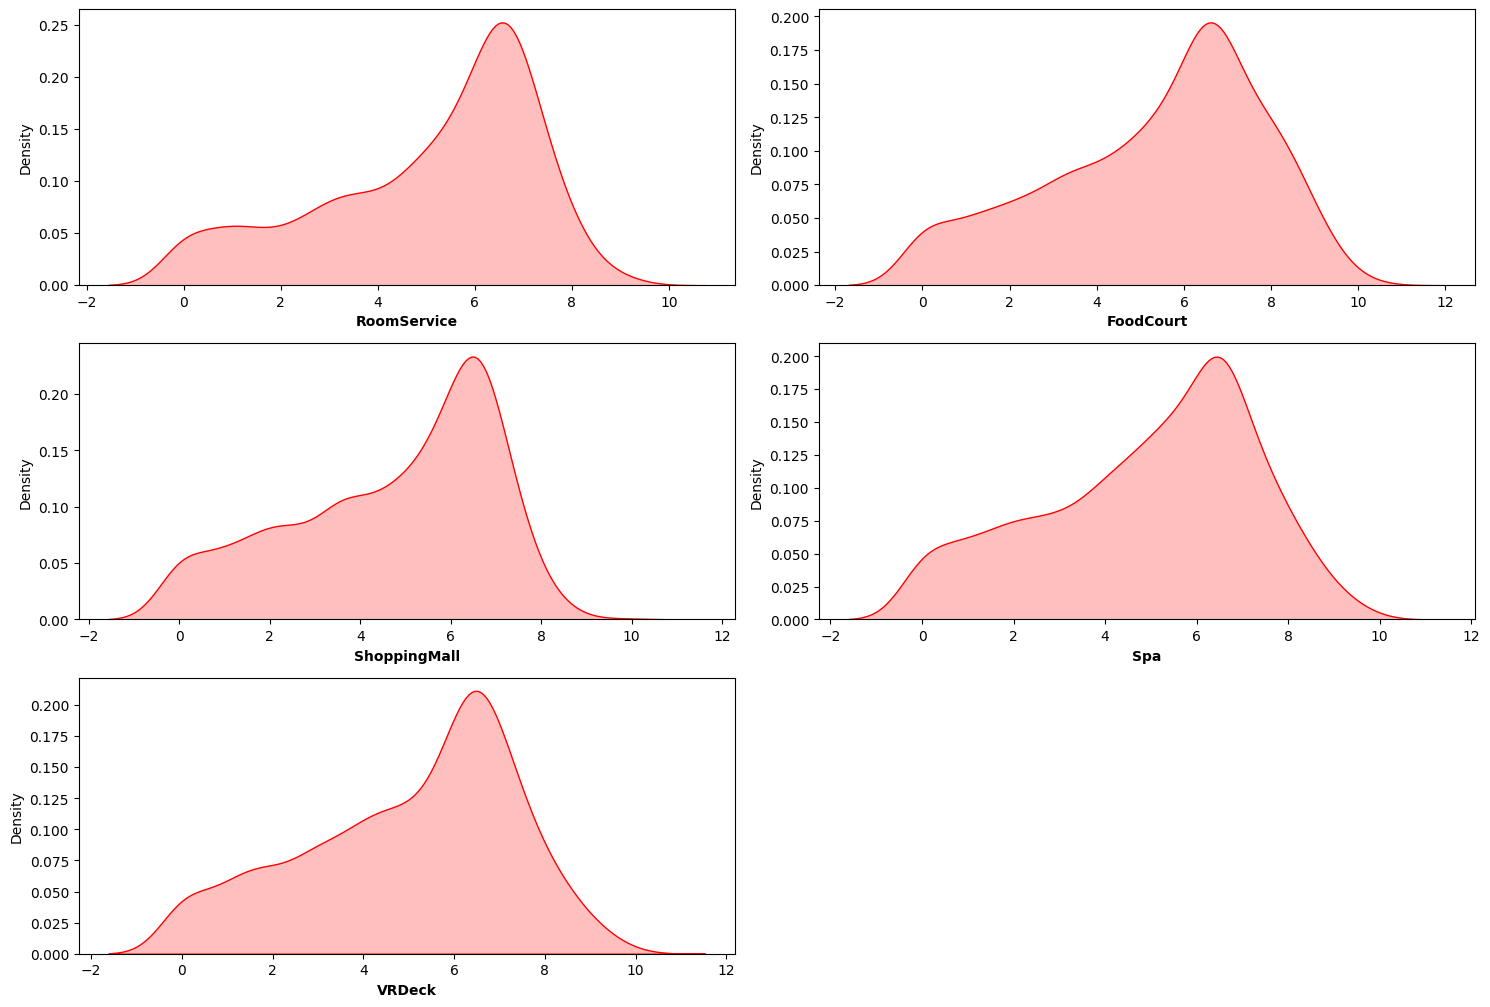

In [32]:
# see https://www.kaggle.com/code/vaasubisht/eda-statisticaltests-gradient-boosting-shap
inbalanced_columns = [col for col in num_columns if(train_data[col].skew()>1)]

# Possible solution could be to prepare the inbalanced columns with log transformation 
plt.figure(figsize=(15, 100))
for i, col in enumerate(inbalanced_columns):
    plt.subplot(30, 2, i+1)
    sns.kdeplot(np.log(train_data[col]),color='red',shade=True)
    plt.xlabel(col, weight='bold')
    plt.tight_layout()

### Set the target column as index and visualize the training data

In [33]:
transported_index = train_data[train_data["Transported"]].set_index("Transported")
not_transported_index = train_data[train_data["Transported"] == False].set_index("Transported")

In [34]:
def plot_hist_subplots(col, title, bins="auto", discrete=None):
    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12,6))
    fig.suptitle(title)
    axes[0].set_title('Transported to new dimension')
    sns.histplot(data=transported_index[col], ax=axes[0], bins=bins, discrete=discrete)
    axes[1].set_title('Not transported to new dimension')
    sns.histplot(data=not_transported_index[col], ax=axes[1], bins=bins, discrete=discrete)

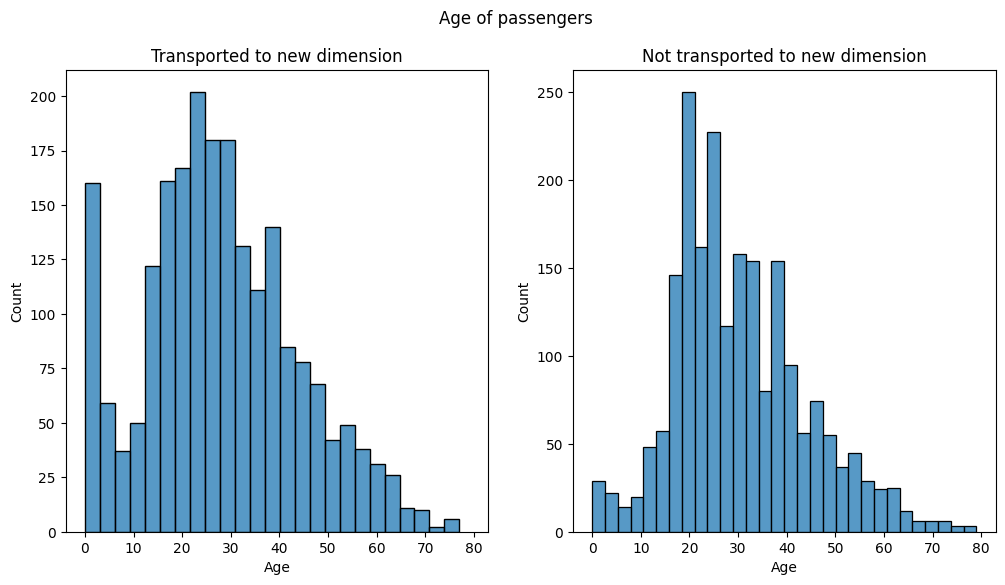

In [36]:
# distribution looks different, age seems to be relevant
plot_hist_subplots(col="Age", title="Age of passengers")

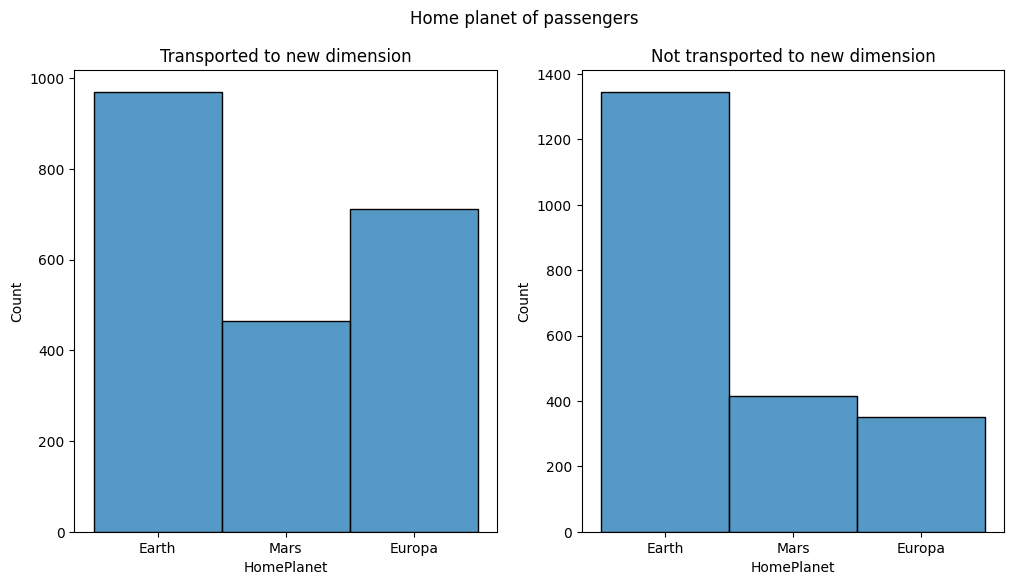

In [37]:
# distribution looks different, home planet seems to be relevant
plot_hist_subplots(col="HomePlanet", title="Home planet of passengers")

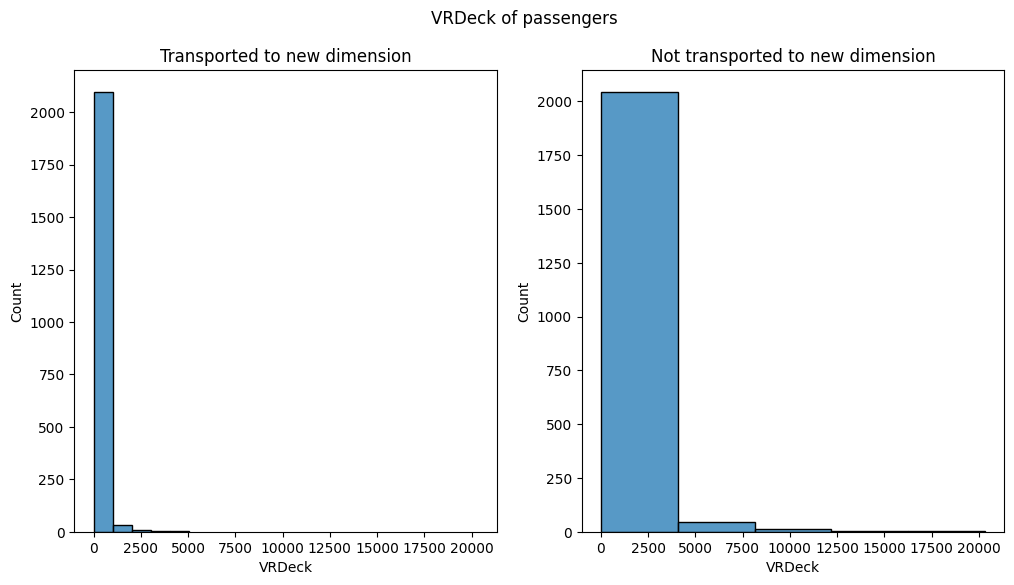

In [38]:
# VR deck looks similair, higher variance on the right
plot_hist_subplots(col="VRDeck", title="VRDeck of passengers", bins=5)

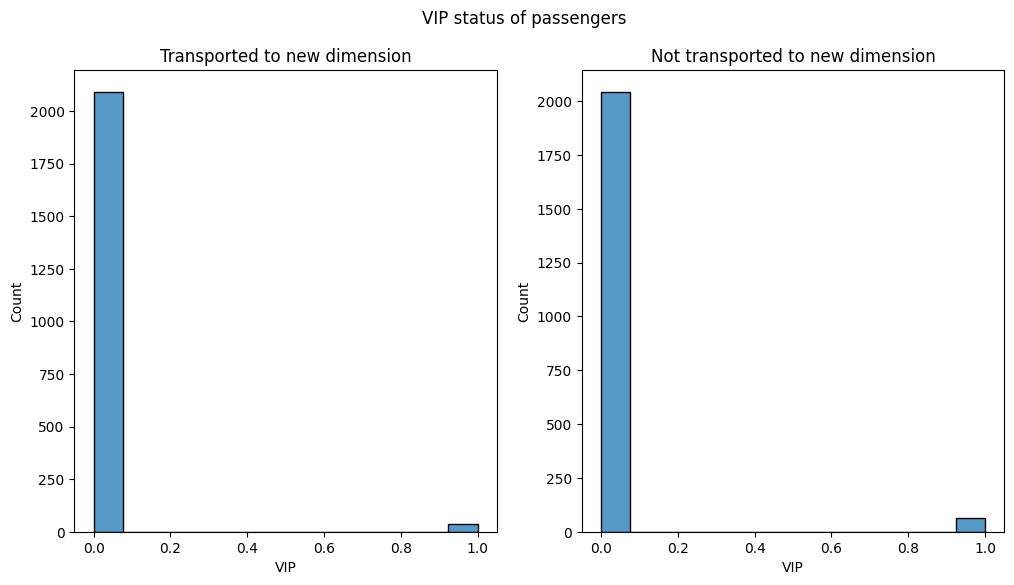

In [39]:
# VIP seems to have no effect
plot_hist_subplots(col="VIP", title="VIP status of passengers")

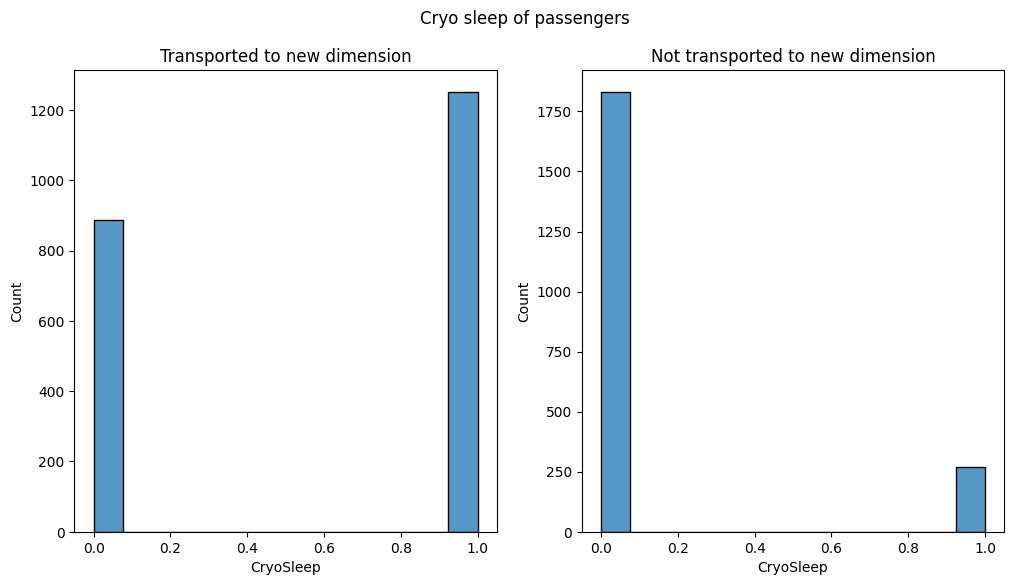

In [40]:
# distribution looks different, cryo sleep seems to be relevant
plot_hist_subplots(col="CryoSleep", title="Cryo sleep of passengers")

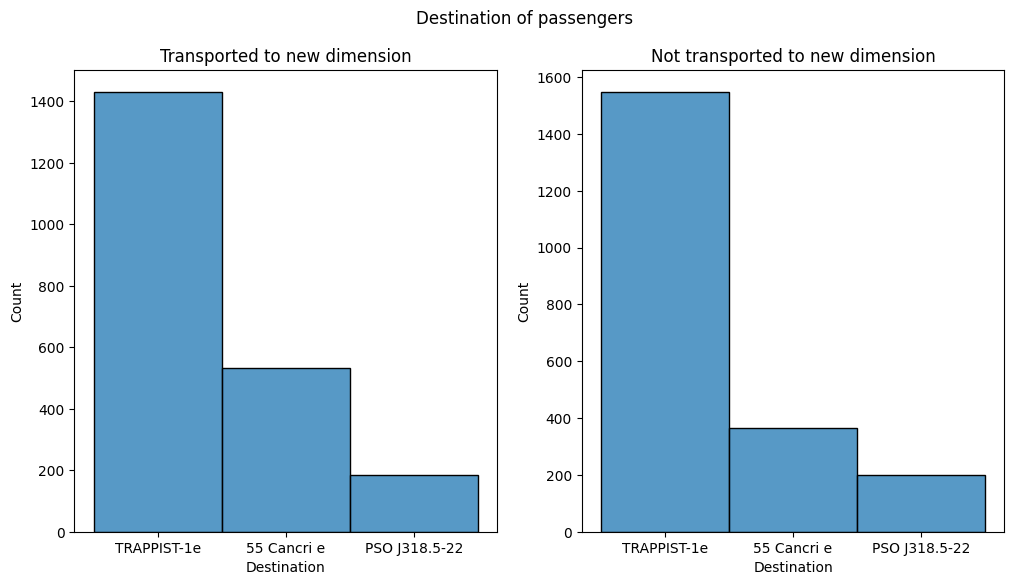

In [41]:
# VR deck looks similair, probably a small effect
plot_hist_subplots(col="Destination", title="Destination of passengers")

### Further analysis of target column differences with relationship (x, y) plots

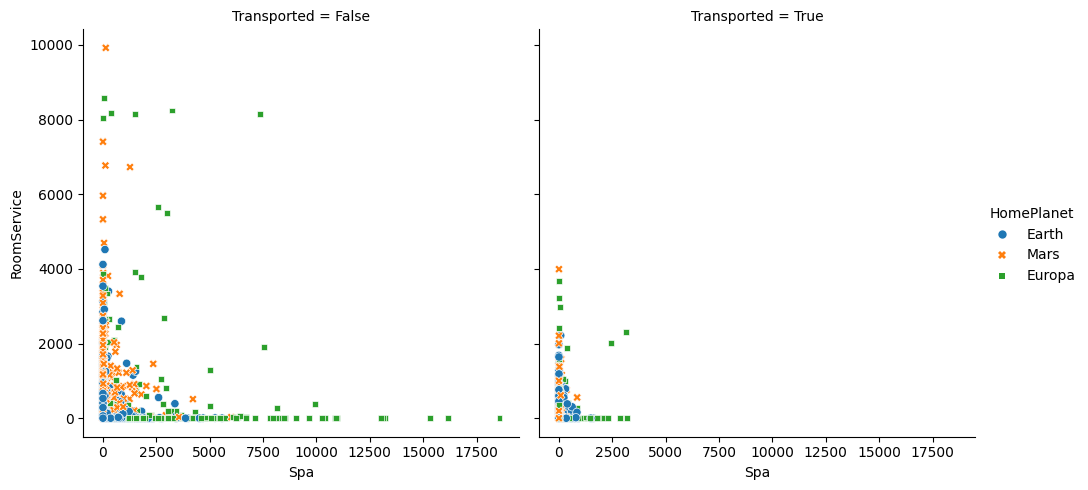

In [49]:
sns.relplot(data=train_data, x="Spa", y="RoomService", col="Transported", hue="HomePlanet", style="HomePlanet")

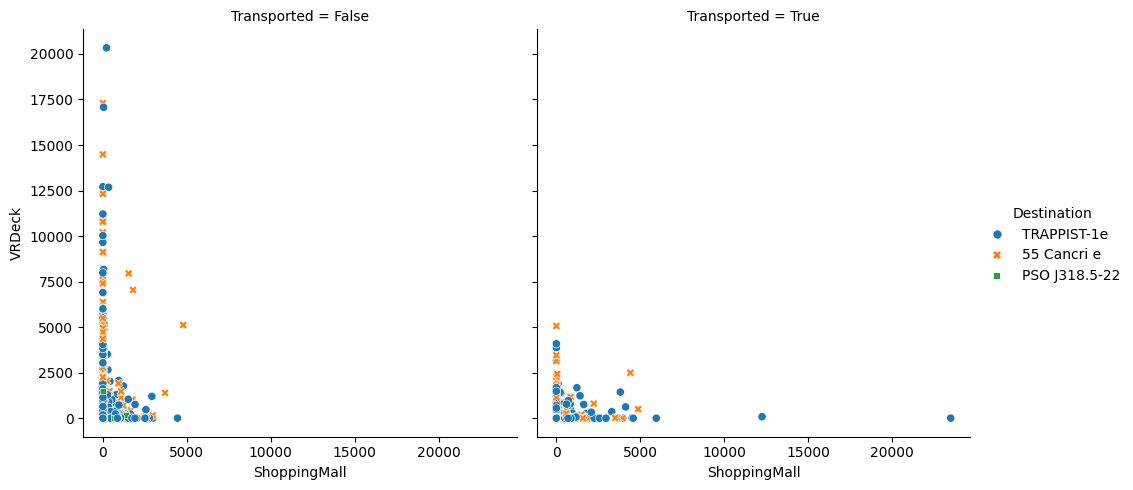

In [50]:
sns.relplot(data=train_data, x="ShoppingMall", y="VRDeck", col="Transported", hue="Destination", style="Destination")

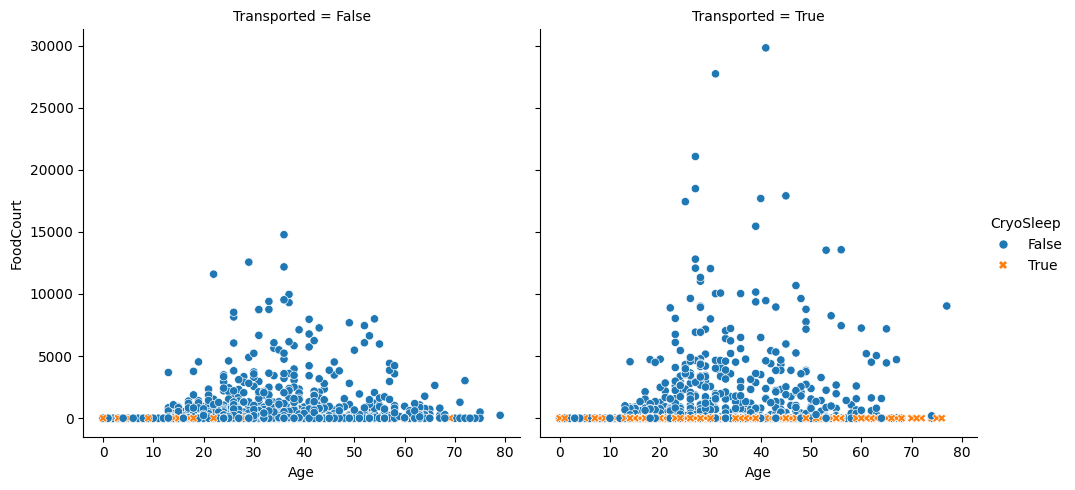

In [51]:
sns.relplot(data=train_data, x="Age", y="FoodCourt", col="Transported", hue="CryoSleep", style="CryoSleep")